### Business Analysis

This notebook provides steps a business analyst might take to determine which customers are likely to churn. The intention is to compare these analyst predictions to the predictions of a machine learning algorithm for the same data set.


In [2]:
import pandas as pd
import io
import requests
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# # import the telco data as a pandas dataframe
# url = "https://s3.amazonaws.com/h2o-smalldata/TelcoChurn.csv"
# content = requests.get(url).content
# telco_df = pd.read_csv(io.StringIO(content.decode('utf-8')))

# pandas dataframe reads in int and numeric columns correctly except for the 'TotalCharges' column
# use converters to read in 'TotalCharges' as a float, and coerce empty string values to NANs

telco_df = pd.read_csv('https://s3.amazonaws.com/h2o-smalldata/TelcoChurn.csv',
                       converters={'TotalCharges':lambda x: pd.to_numeric(x, errors='coerce')})
# get the type of each column
# telco_df.info()
# get the dataframe dimensions
telco_df.shape

(7043, 21)

In [3]:
# get a list of the column names
column_names = telco_df.columns
# get a list of only the categorical columns (and remove response column)
categorical_feature_list = column_names.drop(["customerID",'tenure','Churn', 'MonthlyCharges','TotalCharges'])
# get a list of only numeric or integer columns
num_feature_list = ['tenure','MonthlyCharges', 'TotalCharges']

# check for missing values in each column
for col in column_names:
    if telco_df[col].isnull().sum() > 0:
        print('number of missing values {0} is {1}'.format(col,telco_df[col].isnull().sum()))

number of missing values TotalCharges is 11


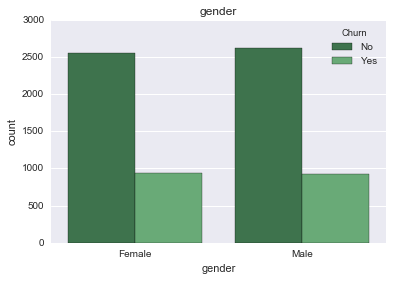

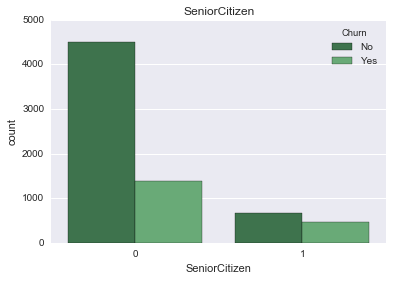

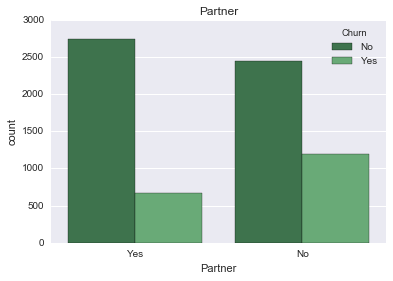

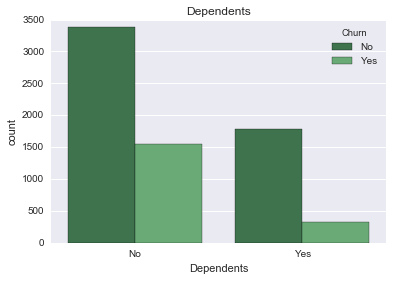

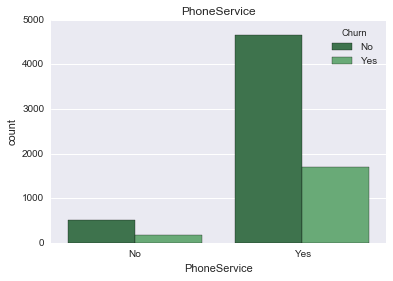

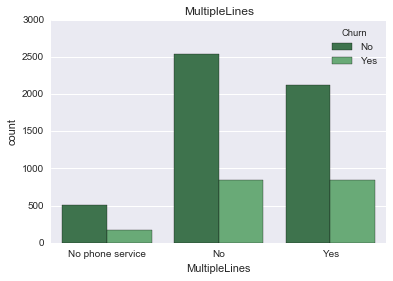

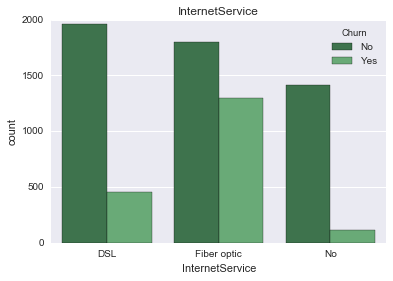

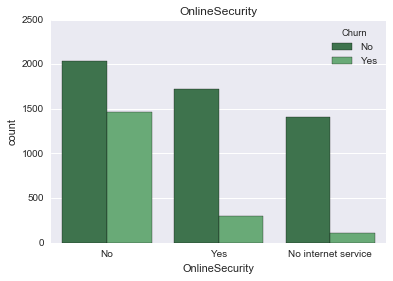

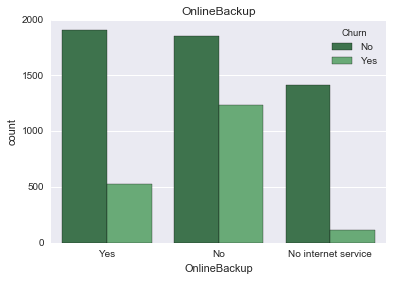

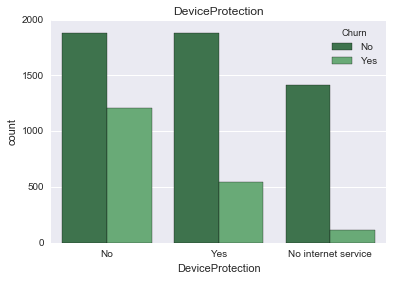

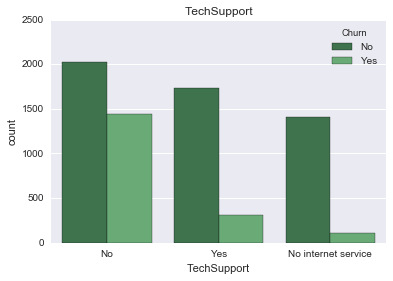

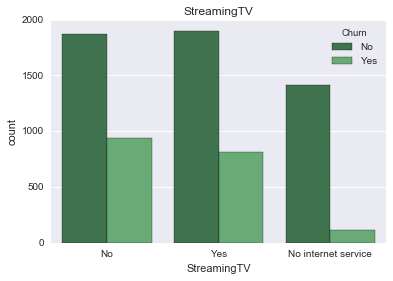

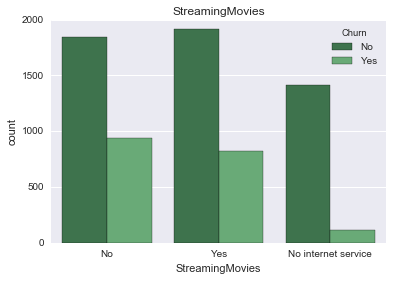

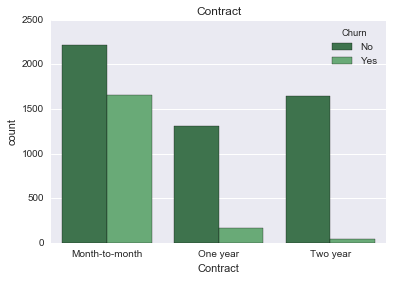

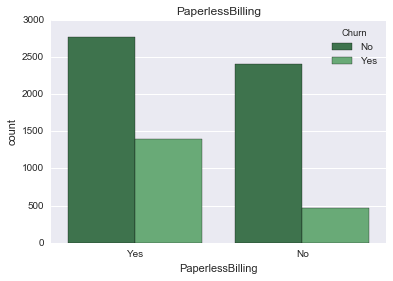

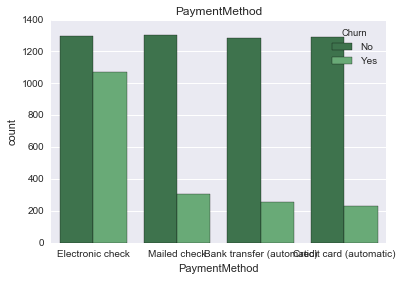

In [4]:
# count plots for all categorical features vs. churn

for col in categorical_feature_list:
    plt.figure()
    #telco_df[col].value_counts().plot(ax=axes[num,0],kind='bar', subplot=True, color='#FFC222')
    #telco_df[col].value_counts().plot(kind='barh', color='#EE3224')
    # sns.countplot(x=col, data=telco_df, palette="Greens_d");
    sns.countplot(x=col, hue="Churn", data=telco_df, palette="Greens_d");
    plt.title(col)
    

In [5]:
# prepare to plot customer tenure against churn, binning tenure into reasonable chunks
# create tenure bins (metric is in months)
tenure_index = [0,8,16,24,32,40,48,56,64,72]

# get the total counts of people who churned "Yes" within each tenure bin
churn_yes_count = []
churn_yes_count.append(telco_df[(telco_df['tenure'] == 0) & (telco_df['Churn'] == "Yes")].shape[0]) 
for index in tenure_index:   
    churn_yes_count.append(telco_df[((telco_df['tenure'] == index) & (telco_df['tenure'] < index + 8)) & (telco_df['Churn'] == "Yes")].shape[0])    

# get the total counts of people who stayed "No" within each tenure bin
churn_no_count = []
churn_no_count.append(telco_df[(telco_df['tenure'] == 0) & (telco_df['Churn'] == "No")].shape[0])  
for index in tenure_index:
    churn_no_count.append(telco_df[((telco_df['tenure'] == index) & (telco_df['tenure'] < index + 8)) & (telco_df['Churn'] == "No")].shape[0])    


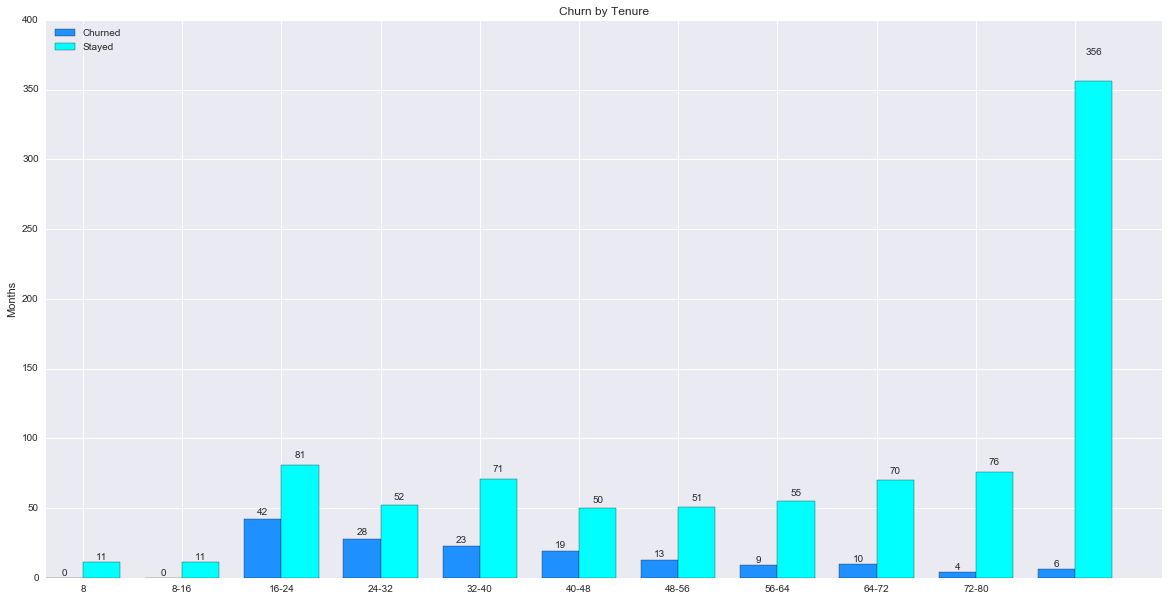

In [6]:
# provide the x indexs and convert to an array
tenure_x_index  = np.array([0,8,16,24,32,40,48,56,64,72,80])
ind = tenure_x_index 

# provide the height values for churn = yes and churn = no
churned_per_bin = churn_yes_count
no_churn_per_bin = churn_no_count

# the width of the bars
width = 3       

# create the figures and plot axis
fig, ax = plt.subplots(figsize=(20, 10))
plt.figure(figsize=(20,10))
rects1 = ax.bar(ind, churned_per_bin, width, color='dodgerblue')
rects2 = ax.bar(ind + width, no_churn_per_bin, width, color='cyan')

#add labels
ax.set_ylabel('Counts')
ax.set_ylabel('Months')
ax.set_title('Churn by Tenure')
ax.set_xticks(ind + width)
ax.set_xticklabels(('8','8-16', '16-24', '24-32', '32-40',
                   '40-48','48-56','56-64' 
                   ,'64-72','72-80'))
ax.legend((rects1[0], rects2[0]), ('Churned', 'Stayed'),loc='upper left')


def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()


In [7]:
# get number of unique values and types of each column
for col in column_names:
    print(col, telco_df[col].nunique())
    if telco_df[col].nunique() < 5:
        #print(col, telco_df[col].unique())
        None

('customerID', 7043)
('gender', 2)
('SeniorCitizen', 2)
('Partner', 2)
('Dependents', 2)
('tenure', 73)
('PhoneService', 2)
('MultipleLines', 3)
('InternetService', 3)
('OnlineSecurity', 3)
('OnlineBackup', 3)
('DeviceProtection', 3)
('TechSupport', 3)
('StreamingTV', 3)
('StreamingMovies', 3)
('Contract', 3)
('PaperlessBilling', 2)
('PaymentMethod', 4)
('MonthlyCharges', 1585)
('TotalCharges', 6530)
('Churn', 2)


In [8]:
# get a sense of the unique types of monthly charges, by rounding floats to integers
feature_data = telco_df["MonthlyCharges"]
print('max:',max(feature_data))
print('min:', min(feature_data))
# round the monthly charges to get a sense of how many unique monthly charges there are
int_feature = feature_data.apply(int)
unique_charges = int_feature .nunique()
print(int_feature .nunique()) 

('max:', 118.75)
('min:', 18.25)
99


('max:', 8684)
('min:', 0)


(array([ 1192.,   573.,   447.,   356.,   336.,   313.,   314.,   251.,
          227.]),
 array([   0,  200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800]),
 <a list of 9 Patch objects>)

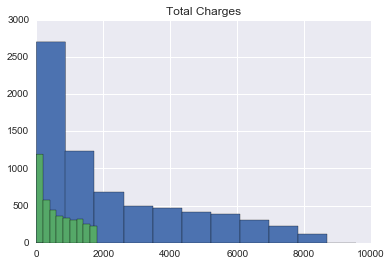

In [9]:
# creat bins for monthly and total charges, based off the min and max and then create a histogram
# replace na values with 0 for the Total Charges which has 11 missing values (these can be calcalted and filled later)
feature_data = telco_df["TotalCharges"].fillna(0)
int_feature = feature_data.apply(int)
print('max:',int(max(feature_data)))
print('min:', int(min(feature_data)))
max_feature = int(max(feature_data))
min_feature = int(min(feature_data))
num_of_bins = 10
binwidth =  (max_feature - min_feature)/num_of_bins
plt.hist(int_feature, bins=range(min_feature, max_feature + binwidth, binwidth))
plt.title("Total Charges")

# focus on the lower end of total changes, limit to the max value where there is drop off plateaus
set_max_value = 2000
num_of_bins = 10
binwidth =  (set_max_value - min_feature)/num_of_bins
plt.hist(int_feature, bins=range(min_feature, set_max_value, binwidth))

('max:', 118)
('min:', 18)


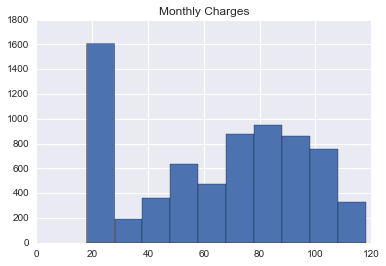

In [10]:
# creat bins for monthly and total charges, based off the min and max and then create a histogram
# replace na values with 0 for the Total Charges which has 11 missing values (these can be calcalted and filled later)
feature_data = telco_df["MonthlyCharges"]
int_feature = feature_data.apply(int)
print('max:',int(max(feature_data)))
print('min:', int(min(feature_data)))
max_feature = int(max(feature_data))
min_feature = int(min(feature_data))
num_of_bins = 10
binwidth =  (max_feature - min_feature)/num_of_bins
plt.hist(int_feature, bins=range(min_feature, max_feature + binwidth, binwidth))
plt.title("Monthly Charges")
# # focus on the lower end of total changes, limit to the max value where there is drop off plateaus
# set_max_value = 2000
# num_of_bins = 10
# binwidth =  (set_max_value - min_feature)/num_of_bins
# plt.hist(int_feature, bins=range(min_feature, set_max_value, binwidth))

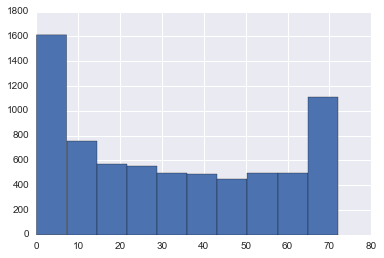

In [11]:
# get histogram of tenure (how long a person has been a customer in months)
telco_df['tenure'].hist()

In [12]:
# create a definition that prints out frequency count tables (pandas crosstab) for each column
def crosstab_freq_table(column_name,dataset):
    crosstab_table = pd.crosstab(index = dataset[column_name], columns="frequency count") 
    return crosstab_table/crosstab_table.sum()
    

In [13]:
# get frequencies for all of the categorical variables
# for col in categorical_feature_list:
#     print crosstab_freq_table(col,telco_df)
#     print ""
#     print"==========================="

In [14]:
# create a definition that allows you to create a crosstab table with two variables and includes row/column tallies
# setting margins = True includes the row and column totals
def crosstab_two_var(index, column, dataset):
    """get the pandas crosstab table with two variables, the column sets the tables columns
    the index sets the tables index, margins = True provides row and column totals"""
    two_var =  pd.crosstab(index = dataset[index], 
                           columns = dataset[column],
                           margins=True)   
    
    # set the columns and indexs to the unique values found in each feature column, and add row/column totals
    two_var.columns = list(telco_df[column].unique())+ ["rowtotal"]
    two_var.index = list(telco_df[index].unique())+ ["coltotal"]
    # divide the table by the grand total to get the total proportion of counts in each cell 
#     two_var_proportion = two_var.ix[:,0:2]/two_var.ix["coltotal"][:-1]
#     two_var_proportion["rowtotal"] = two_var["rowtotal"]/two_var.ix["coltotal"][:-1]
    two_var_proportion = two_var/two_var.ix["coltotal"]
    return two_var_proportion
    # comment the line above, and uncomment the line below to get the counts instead of proportions
    #return two_var


In [15]:
# To do: USE SIGNIFICANcd TESTING 
# get the proportions of those who churn within each level for all of the categorical variables
# removed row total, could add it back?
for col in categorical_feature_list:
    print "==========================="
    print "Churn vs.", col
    print "==========================="
    print crosstab_two_var("Churn", col, telco_df)
    print "==========================="

Churn vs. gender
            Female      Male  rowtotal
No        0.730791  0.738397   0.73463
Yes       0.269209  0.261603   0.26537
coltotal  1.000000  1.000000   1.00000
Churn vs. SeniorCitizen
                 0         1  rowtotal
No        0.763938  0.583187   0.73463
Yes       0.236062  0.416813   0.26537
coltotal  1.000000  1.000000   1.00000
Churn vs. Partner
              Yes        No  rowtotal
No        0.67042  0.803351   0.73463
Yes       0.32958  0.196649   0.26537
coltotal  1.00000  1.000000   1.00000
Churn vs. Dependents
                No       Yes  rowtotal
No        0.687209  0.845498   0.73463
Yes       0.312791  0.154502   0.26537
coltotal  1.000000  1.000000   1.00000
Churn vs. PhoneService
                No       Yes  rowtotal
No        0.750733  0.732904   0.73463
Yes       0.249267  0.267096   0.26537
coltotal  1.000000  1.000000   1.00000
Churn vs. MultipleLines
          No phone service        No       Yes  rowtotal
No                0.749558  0.750733  0.

In [63]:
# Set the values of interest here:

# categorical dictionary of values that seem correlated with Churn:
# the dictionary is created to you can check if a feature is equal to a churn correlated level
cat_dict = {
    'gender': [], # gender does seem correlated with churn
    'SeniorCitizen': [1], # younger people are less likely to churn 
    'Partner':['Yes'], 
    'Dependents': ["No"],
    'PhoneService': [],
    'MultipleLines':["Yes"], # not a strong indicator, but maybe more lines means people need the best deal 
    'PaperlessBilling': ['Yes'],
    'InternetService': ["Fiber optic"],
    'OnlineSecurity' : ['No'],
    'OnlineBackup': ['Yes'],
    'DeviceProtection': ['No'],
    'TechSupport': ['No'],
    'StreamingTV': ['No'],
    'StreamingMovies': ['No'],
    'Contract': ['Month-to-month'],
    'PaperlessBilling': ['No'],
    'PaymentMethod': ["Bank transfer (automatic)"]
    
}


# numerical dictory of cut off values for Churn correlation:
num_dict = {
    'tenure': [telco_df['tenure'].median()],
    'MonthlyCharges': [telco_df['MonthlyCharges'].median()],
    'TotalCharges': [telco_df['TotalCharges'].median()]
}


# feature list: the list of columns that you believe are correlated with churn
# important_feature_list = ["tenure", 'Contract', 'PaymentMethod']
important_feature_list = ["tenure", 'TechSupport']

In [51]:
# # This version is hard coded to be used with 'tenure' 
# # change the values in this line (instead of 20 and 11) to see different results:
# # boolean_df[column] = dataframe[column].map(lambda x: True if x <= (20) and (x >= 11) else False)
# def boolean_matrix(important_features,dataframe,categorical_dict, numerical_dict, threshold = None):
#     if threshold == None:
#         threshold = len(important_features)
#     boolean_df = pd.DataFrame()
#     # subset the dataframe to only consider the important feature columns
#     dataframe = dataframe[important_features]
#     for column in dataframe.columns:
#         if type(dataframe[column][0]) == str:
#             boolean_df[column] = dataframe[column].isin(categorical_dict[column])
        
#         elif (type(dataframe[column][0]) == np.int64) or (type(dataframe[column][0]) == np.float64):
#             boolean_df[column] = dataframe[column].map(lambda x: True if x <= (20) and (x >= 11) else False)
#         else:
#             print "something went wrong"
#     # sum over all the 1s and 0s to get a count of features that correlated with churn
#     # if sum of row is equal to the length of important_feature set equal to "Yes" they will churn
#     print boolean_df.head()
#     new_column = boolean_df.sum(axis=1).map(lambda x: "Yes" if x >= threshold else "No")
#     # convert the pandas series into a dataframe
#     new_column = pd.DataFrame(new_column)
#     # set the column title to predicted_churn
#     new_column.columns = ['predicted_churn']
#     return new_column

In [64]:
# Use this definition
def boolean_matrix(important_features,dataframe,categorical_dict, numerical_dict, threshold = None):
    """returns a boolean column with True if a row contained the values in the categorical dictionary
    or less than the values given in the numerical dictionary, returns False if the row does not contain
    the same values as the dictionaries in one or more of the features given in 'important_features' list."""
    
    if threshold == None:
        threshold = len(important_features)
    boolean_df = pd.DataFrame()
    # subset the dataframe to only consider the important feature columns
    dataframe = dataframe[important_features]
    for column in dataframe.columns:
        if type(dataframe[column][0]) == str:
            boolean_df[column] = dataframe[column].isin(categorical_dict[column])
        
        elif (type(dataframe[column][0]) == np.int64) or (type(dataframe[column][0]) == np.float64):
            boolean_df[column] = dataframe[column].map(lambda x: True if x <= numerical_dict[column][0] else False)
        else:
            print "something went wrong"
    # sum over all the 1s and 0s to get a count of features that correlated with churn
    # if sum of row is equal to the length of important_feature set equal to "Yes" they will churn
    print boolean_df.head()
    new_column = boolean_df.sum(axis=1).map(lambda x: "Yes" if x >= threshold else "No")
    # convert the pandas series into a dataframe
    new_column = pd.DataFrame(new_column)
    # set the column title to predicted_churn
    new_column.columns = ['predicted_churn']
    return new_column


In [71]:
# important_feature_list = ["tenure", 'PaymentMethod']
important_feature_list = ["tenure"]
# update inputs a few cells above
new_col = boolean_matrix(important_feature_list,telco_df,cat_dict, num_dict, threshold = 2)

# print out the true/false results for the rule based predicted churn column
telco_df['predicted_churn'] = new_col

telco_df.head()

  tenure
0   True
1  False
2   True
3  False
4   True


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,predicted_churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,No
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,No


In [72]:
# get the auc score (first convert back to 0/1 values to sklearn can interpret)
from sklearn.metrics import roc_auc_score
y_true = telco_df['Churn'].map(lambda x: 1 if x == "Yes" else 0)
y_scores = telco_df['predicted_churn'].map(lambda x: 1 if x == "Yes" else 0)
print 'the AUC Score', roc_auc_score(y_true, y_scores)

# Check if scores make sense:
# print y_true[y_true==0].count()
# print y_scores[y_scores==0].count()

the AUC Score 0.5


In [20]:
# create a crosstab table for three variables

def crosstab_three(index, col_1, col_2, dataset):
    crosstab_three_var = pd.crosstab(index =dataset[index], 
                                 columns=[dataset[col_1],
                                          dataset[col_2]],
                                 margins=True)   # Include row and column totals

    return crosstab_three_var

# create a crosstab for four tables

def crosstab_four(index, col_1, col_2, col_3, dataset):
    crosstab_four_var = pd.crosstab(index =dataset[index], 
                                 columns=[dataset[col_1],
                                          dataset[col_2],
                                          dataset[col_3]],
                                 margins=True)   # Include row and column totals

    return crosstab_four_var

In [21]:
crosstab_three("Churn", "Contract", "PaymentMethod", telco_df)

Contract                 Month-to-month                          \
PaymentMethod Bank transfer (automatic) Credit card (automatic)   
Churn                                                             
No                                  388                     365   
Yes                                 201                     178   
All                                 589                     543   

Contract                                                     One year  \
PaymentMethod Electronic check Mailed check Bank transfer (automatic)   
Churn                                                                   
No                         856          611                       353   
Yes                        994          282                        38   
All                       1850          893                       391   

Contract                                                             \
PaymentMethod Credit card (automatic) Electronic check Mailed check   
Churn                                                                 
No                                357              283          314   
Yes                                41               64           23   
All                               398              347          337   

Contract                       Two year                          \
PaymentMethod Bank transfer (automatic) Credit card (automatic)   
Churn                                                             
No                                  545                     568   
Yes                                  19                      13   
All                                 564                     581   

Contract                                      All  
PaymentMethod Electronic check Mailed check        
Churn                                              
No                         155          379  5174  
Yes                         13            3  1869  
All                        168          382  7043

In [22]:
crosstab_four("Churn", "Contract", "PaymentMethod", "InternetService", telco_df)

Contract                   Month-to-month                  \
PaymentMethod   Bank transfer (automatic)                   
InternetService                       DSL Fiber optic  No   
Churn                                                       
No                                    158         178  52   
Yes                                    39         149  13   
All                                   197         327  65   

Contract                                                                  \
PaymentMethod   Credit card (automatic)                 Electronic check   
InternetService                     DSL Fiber optic  No              DSL   
Churn                                                                      
No                                  135         171  59              282   
Yes                                  50         122   6              192   
All                                 185         293  65              474   

Contract                                      ...                 Two year  \
PaymentMethod                   Mailed check  ...  Credit card (automatic)   
InternetService Fiber optic  No          DSL  ...                      DSL   
Churn                                         ...                            
No                      518  56          254  ...                      232   
Yes                     789  13          113  ...                        5   
All                    1307  69          367  ...                      237   

Contract                                                           \
PaymentMethod                    Electronic check                   
InternetService Fiber optic   No              DSL Fiber optic  No   
Churn                                                               
No                      148  188               54          83  18   
Yes                       6    2                4           9   0   
All                     154  190               58          92  18   

Contract                                        All  
PaymentMethod   Mailed check                         
InternetService          DSL Fiber optic   No        
Churn                                                
No                       109          20  250  5174  
Yes                        0           1    2  1869  
All                      109          21  252  7043  

[3 rows x 37 columns]

In [23]:
# looking at the plots, identify features that have the most people
# ie: payment method = electorinic check
# contract: month-to-month
# tech support = No
# anyone who has no internet service (not as dedicated of a customer)
# non senior citizens
# tenure under 24 months
## anyone on a two year contract that has a tenure of 20 - 24 months

In [24]:
# let's get a list of all our most loyal customers by looking at people with
# the longest tenure, 
# highest TotalCharges,
# type of contract


# let's also get a few groupings of people who we think are likely to churn:
# people with month-to-month contracs (Contract)
# people who pay with electronic check or mail check (PaymentMethod)
# people who only have one or none of the following internet services (DeviceProtection,TechSupport,StreamingTV,StreamingMovies)


# lets also get a group of people who we think would be persuaded to stay if they got a coupon
#
